<font size="6">Titanic Machine Learning Project</font>

Author: Maelynn Hunter<br/>
Overview: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

---

Data and competition information:
* https://www.kaggle.com/competitions/titanic/overview

---

# Environment Setup

* Data manipulation: Numpy, Pandas
* Data visualization: Matplotlib, Seaborn
* Machine learning: Scikit-Learn

In [1]:
# data processing
import numpy as np 
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# visual settings
sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'0.15', 'axes.grid':True, 'xtick.bottom': True, 
                           'xtick.top': False, 'ytick.left': True, 'ytick.right': False, 'patch.edgecolor': '0.15'})
sns.set_palette('Pastel1')

# Loading Data

In [3]:
# load training data into DataFrame
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# load test data into DataFrame
test_data = pd.read_csv('test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploratory Data Analysis

<font size="4">How many people survived?</font>

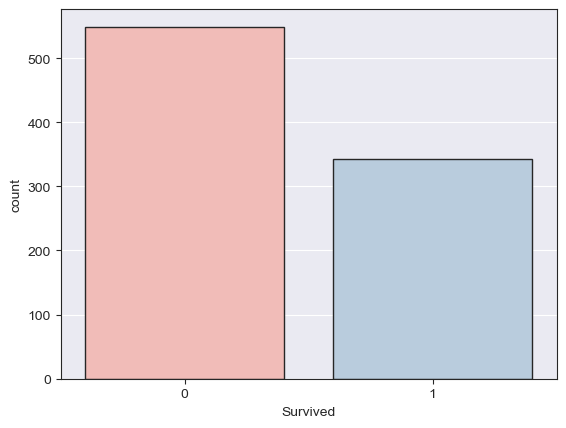

In [5]:
sns.countplot(x='Survived', data=train_data);

Most people on the Titanic did not survive.

<font size="4">How did sex affect survivorship?</font>

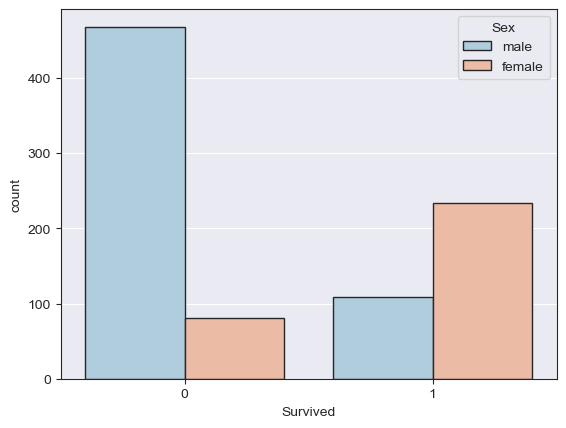

In [6]:
sns.countplot(x='Survived', data=train_data, hue='Sex', palette='RdBu_r');

People who did not survive were overwhelmingly male, while people who survived were mostly female.

<font size="4">How did class affect survivorship?</font>

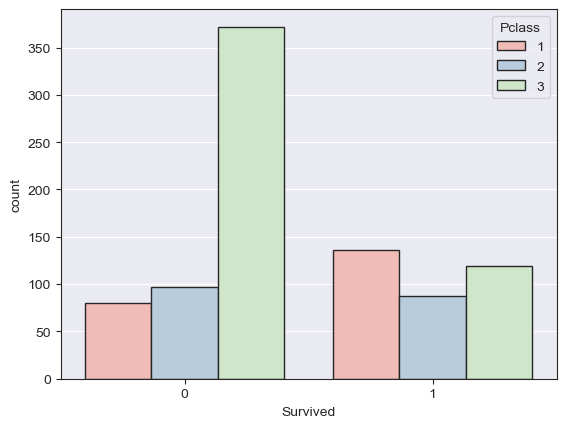

In [7]:
sns.countplot(x='Survived', data=train_data, hue='Pclass');

The people who did not survive were mostly comprised of people in the third class. People who did survive leaned slightly toward first class.

# Data Cleaning

### Missing Values: train_data

Where is data missing?

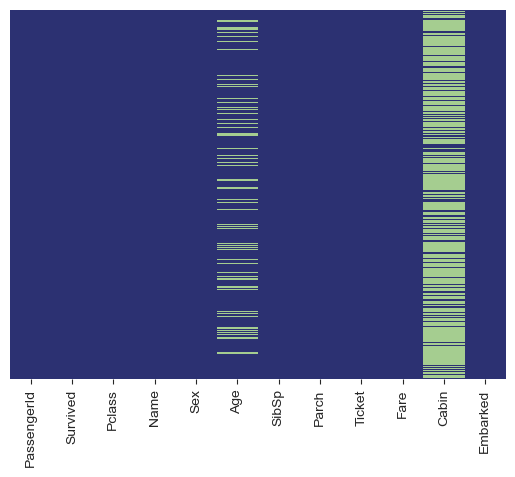

In [8]:
# null data as a boolean viewed in heatmap
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='crest_r');

There is some data missing from the age column, but there are enough remaining values that we can determine a realistic age based on the other data. A lot of the cabin data is missing, and we will likely not be able to use it.

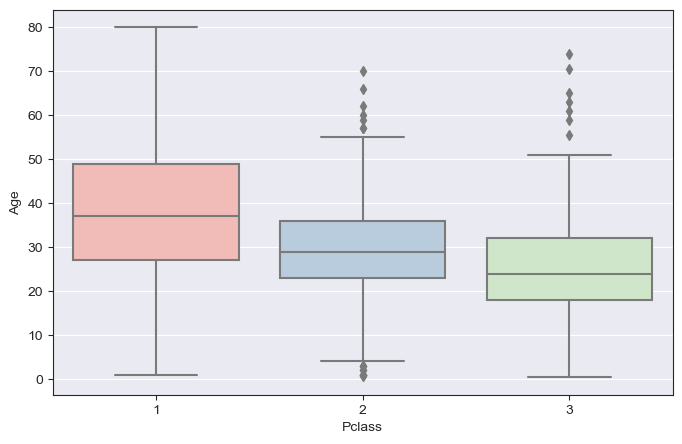

In [9]:
# age of passengers based on class
plt.figure(figsize=(8,5))
sns.boxplot(x='Pclass', y='Age', data=train_data);

Wealthier passengers tend to be older than those in the lower classes. We can use these averages to fill in the ages of passengers based on their class.

In [10]:
# function to determine likely age of passengers based on the average for that class
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass ==2:
            return 29
        else:
            return 24
    else:
        return Age

In [11]:
# apply function
train_data['Age'] = train_data[['Age', 'Pclass']].apply(impute_age, axis=1)

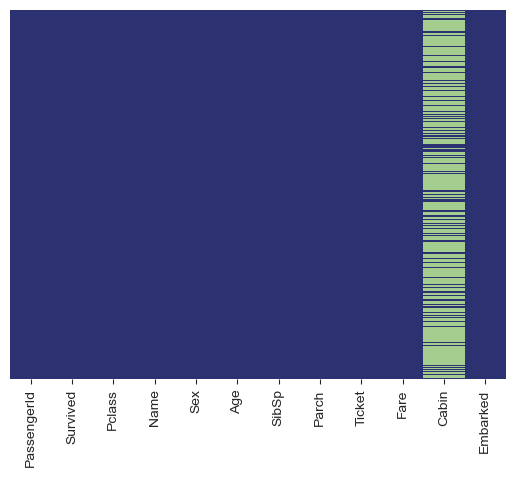

In [12]:
# null data as a boolean viewed in heatmap
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='crest_r');

Now we have filled in all of the age gaps with the average age of the passengers based on their class. Since the cabin column has so many missing values, we will drop it.

In [13]:
# drop cabin column
train_data.drop('Cabin', axis=1, inplace=True)

### Categorical Features: train_data

For categorical columns like Sex and Embarked, we will convert the categories to numerical values (indicator/dummy variables)

In [14]:
# convert sex into numerical values (0/1) in one column
sex = pd.get_dummies(train_data['Sex'], drop_first=True)
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [15]:
# convert embark into numerical values (0/1) in two columns
embark = pd.get_dummies(train_data['Embarked'], drop_first=True)
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [16]:
# concatenating dummy variable columns to original table
train_data = pd.concat([train_data,sex,embark], axis=1)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


Now, we need to do the same cleaning to the test data

### Missing Values: test_data

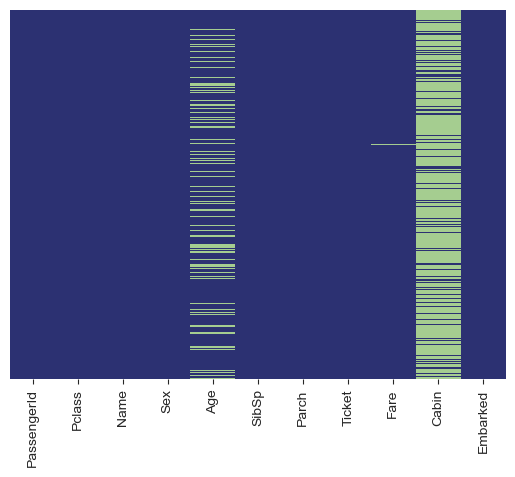

In [17]:
# null data as a boolean viewed in heatmap
sns.heatmap(test_data.isnull(), yticklabels=False, cbar=False, cmap='crest_r');

In [18]:
# function to determine likely age of passengers based on average for that class
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age
    
# apply function
test_data['Age'] = test_data[['Age', 'Pclass']].apply(impute_age, axis=1)

In [19]:
# drop cabin column
test_data.drop('Cabin', axis=1, inplace=True)

The test data is also missing some data in the fare column:

In [20]:
# function to determine likely fare paid based on average for that class
def impute_fare(cols):
    Fare = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Fare):
        if Pclass == 1:
            return test_data[test_data['Pclass']==1]['Fare'].mean()
        elif Pclass == 2:
            return test_data[test_data['Pclass']==2]['Fare'].mean()
        else:
            return test_data[test_data['Pclass']==3]['Fare'].mean()
    else:
        return Fare
    
# apply function
test_data['Fare'] = test_data[['Fare', 'Pclass']].apply(impute_fare, axis=1)

### Categorical Features: test_data

In [21]:
# convert sex into numerical values (0/1) in one column
sex = pd.get_dummies(test_data['Sex'], drop_first=True)
sex.head()

,male
0,1
1,0
2,1
3,1
4,0


In [22]:
# convert embark into numerical values (0/1) in two columns
embark = pd.get_dummies(test_data['Embarked'], drop_first=True)
embark.head()

,Q,S
0,1,0
1,0,1
2,1,0
3,0,1
4,0,1


In [23]:
# concatenating dummy variable columns to original table
test_data = pd.concat([test_data,sex,embark], axis=1)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,0,0,1


# Train/Test Split

In order to test our model for accuracy, we will split the data with known outcomes (train_data) into a training set and a testing set.

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# training set features
X = train_data.drop(['Name', 'Sex', 'Ticket', 'Embarked', 'PassengerId', 'Survived'], axis=1)
# training set target variable
y = train_data['Survived']

In [26]:
# split training data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
# create Random Forest Classifier object
rfc = RandomForestClassifier(n_estimators=200)

In [29]:
# train the model
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [30]:
# predict outcomes of the training test set
predictions = rfc.predict(X_test)

# Model Evaluation

In [31]:
from sklearn.metrics import confusion_matrix,classification_report

In [32]:
print(confusion_matrix(y_test,predictions))

[[164  24]
 [ 30  77]]


The confusion matrix shows that the model made 164 true negative predictions and 77 true positive predictions. The model made 24 false positive predictions and 30 false negative predictions.

In [33]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       188
           1       0.76      0.72      0.74       107

    accuracy                           0.82       295
   macro avg       0.80      0.80      0.80       295
weighted avg       0.82      0.82      0.82       295



The overall accuracy of the model was 0.82 or 82%

# Final Test

In [34]:
# test set features
X_test_final = test_data.drop(['Name', 'Sex', 'Ticket', 'Embarked', 'PassengerId'], axis=1)

In [35]:
# predict outcomes of final test set
final_predictions = rfc.predict(X_test_final)

In [36]:
# create csv file for submission to https://www.kaggle.com/competitions/titanic/overview
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': final_predictions})
output.to_csv('submission.csv', index=False)

Because the final test set data doesn't reveal whether passengers survived, I'm not able to complete a confusion matrix and classification report for the final test set.

My submission on Kaggle received a score of 0.72966, or 73% accuracy of predicting which passengers survived the Titanic.